# Classification

In [1]:
# Imports required packages

import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, \
                            recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.base import clone

import matplotlib.pyplot as plt

## Loading Data Set

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

In [2]:
# Fetches the data set and caches it

# NOTE: This step may take several seconds to complete as it downloads 
# the data from web and then caches it locally

mnist = fetch_openml("mnist_784", as_frame=False)

In [3]:
# Checks the properties available with mnist object
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


So, mnist.data and mnist.target will provide the data set and target respectively. Other properties might not be applicable as far as this experiment is concerned.

## Exploratory Data Analysis (EDA)

In [4]:
# Finds the shape of the data (excluding target)
print(mnist.data.shape)

(70000, 784)


In [5]:
# Similarly, finds the shape of the target
print(mnist.target.shape)

(70000,)


In [8]:
# Let's view the target
print(mnist.target)

['5' '0' '4' ... '4' '5' '6']


In [9]:
mnist.target = mnist.target.astype(int)

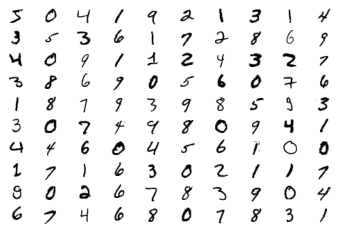

In [10]:
# Let's plot first 100 handwritten digits in a 10x10 subplots in a figure

for idx, image_data in enumerate(mnist.data[:100]):
    plt.subplot(10, 10, idx + 1)
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

plt.show()

## Training a Binary Classifier
Though the data set is a multiclass data set, let's first convert this problem as binary classification problem. It will just detect 5 and not-5 - the two classes.

In [11]:
# Creates binary vector for target - True for all 5s and False for all other digits
y_5 = (mnist.target == 5)

print(y_5)

[ True False False ... False  True False]


In [12]:
# Split the data set into train and test data set.

# NOTE: Data set is already shuffled, and no further shuffling is being performed here

X_train, X_test, y_train_5, y_test_5 = \
    mnist.data[:60000], mnist.data[60000:], y_5[:60000], y_5[60000:]

In [13]:
# Let's start with Stochastic Gradient Descent (SGD) classifier as this classifier
# has advantage of handling large data sets efficiently

# Instantiate the the classifier (with default parameters)

# NOTE: This step may take several seconds to complete

sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)
#sgd_clf.fit(X_train, y_train_5)

## Performance Measures

### Measuring Accuracy using Cross-Validation (CV)

In [14]:
# Instantiates stratifier to provide observation indexes
# to obtain train and validation data set splits ensuring same distribution

# NOTE: This block execution may take several seconds to few minutes to complete
# Also note that the below code is the implementation of built-in function cross_val_score(),
# and is given here for reference purpose.

n_splits = 5    # Let's be it a 5-fold cross validation

skfolds = StratifiedKFold(n_splits=n_splits)  # Object 

cv_accuracy_scores = []  # List to hold accuracy score for each fold

step_counter = 1  # Just to show a progress counter for CV to complete

# Starts CV. 
# *_index variables hold indexes for current fold
for train_index, val_index in skfolds.split(X_train, y_train_5):
    print("Current fold: {}...\t".format(step_counter), end="")
    
    cloned_clf = clone(sgd_clf)  # Clones default classifier in each fold
    
    # Prepares train and validation data set based on current fold
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_val_fold = X_train[val_index]
    y_val_fold = y_train_5[val_index]
    
    print("Performing training and predictions...", end="")
    
    cloned_clf.fit(X_train_folds, y_train_folds)    # Fits the classifier to train data
    
    cv_predictions = cloned_clf.predict(X_val_fold)  # Makes prediction on validation data
    
    # Calculates CV accuracy
    cv_accuracy_score = accuracy_score(y_val_fold, cv_predictions)
    
    cv_accuracy_scores.append(cv_accuracy_score)    # Adds the CV accuracy score to a list
    
    print("done.")
    
    # Marks to free memory
    del cloned_clf, cv_predictions, X_train_folds, y_train_folds, X_val_fold, y_val_fold
    
    step_counter += 1    # Increases counter to show progress
    
print("\n{}-fold cross-validation accuracy scores: {}".format(n_splits, cv_accuracy_scores))

Current fold: 1...	Performing training and predictions...done.
Current fold: 2...	Performing training and predictions...done.
Current fold: 3...	Performing training and predictions...done.
Current fold: 4...	Performing training and predictions...done.
Current fold: 5...	Performing training and predictions...done.

5-fold cross-validation accuracy scores: [0.9546666666666667, 0.96975, 0.9635, 0.9653333333333334, 0.9484166666666667]


In [15]:
print("Mean accuracy is", np.mean(cv_accuracy_scores))

Mean accuracy is 0.9603333333333334


The above accuracy may not be a correct approximation of the model's performance because if the model just predicts _False_ for all the validation test data then accuracy will anyway be around 90% as non-5 images occupy 90% of the total validation test data in each fold. So, this demonstrates that **accuracy is not always the preferred performance measure for classifiers**.

### Confusion Matrix

The general idea about the confusion matrix is that it counts the number of times each class is predicted to be that class giving more information about the performance of the classifier. It outputs a matrix where one axis is for actual class and other axis is for predicted class.

In [16]:
# Now, to create confusion matrix, let's first obtain the prediction over cross validation
# NOTE: This step may take several seconds to complete

cv_predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

In [17]:
# Prints the cross validation predictions
print("CV Predictions:", cv_predictions)

CV Predictions: [ True False False ...  True False False]


In [18]:
# Builds confusion matrix
cv_confusion_matrix = confusion_matrix(y_train_5, cv_predictions)

In [19]:
# Prints the confusion matrix
print("Confusion matrix:\n", cv_confusion_matrix)

Confusion matrix:
 [[53115  1464]
 [  916  4505]]


In [20]:
# Converts the array representation of confusion matrix into DataFrame for easy understanding
cv_confusion_matrix_df = pd.DataFrame(
    cv_confusion_matrix, index=["True non-5", "True 5"], columns=["Predicted as non-5", "Predicted as 5"])
display(cv_confusion_matrix_df)

,Predicted as non-5,Predicted as 5
True non-5,53115,1464
True 5,916,4505


In [21]:
# Shows the DataFrame version of confusion matrix
display(cv_confusion_matrix_df)

,Predicted as non-5,Predicted as 5
True non-5,53115,1464
True 5,916,4505


In [23]:
# Calculates True Negative, False Positive, True Positive and False Negative

true_positive = cv_confusion_matrix_df.loc["True 5"]["Predicted as 5"]
false_positive = cv_confusion_matrix_df.loc["True non-5"]["Predicted as 5"]
true_negative = cv_confusion_matrix_df.loc["True non-5"]["Predicted as non-5"]
false_negative = cv_confusion_matrix_df.loc["True 5"]["Predicted as non-5"]

print("TP: {}, FP: {}, TN: {}, FN: {}".format(
    true_positive, false_positive, true_negative, false_negative))

TP: 4505, FP: 1464, TN: 53115, FN: 916


**Accuracy of the Positive Predictions**

$$precision=\frac{True Positive (TP)}{True Positive (TP)+False Positive (FP)}$$

**True Positive Rate (TPR) or Sensitivity**

$$recall=\frac{True Positive (TP)}{True Positive (TP)+False Negative (FN)}$$

In [24]:
# Calculates precision - measure of accuracy for positive predictions

cv_precision_score = precision_score(y_train_5, cv_predictions)
cv_recall_score = recall_score(y_train_5, cv_predictions)

print("Precision: {}\nRecall: {}".format(cv_precision_score, cv_recall_score))

Precision: 0.7547327860613168
Recall: 0.8310274857037447


**F1 Score - Harmonic Mean of Precision and Recall**

$$F_1=\frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}=2 \times \frac{Precision \times Recall}{Precision+Recall} = \frac{TP}{TP + \frac{FN+FP}{2}}$$

In [25]:
# Calculates F1 score - the Harmonic Mean of Precision and Recall

cv_f1_score = f1_score(y_train_5, cv_predictions)
print("F1 score:", cv_f1_score)

F1 score: 0.791044776119403


### Precision/Recall Trade-off

The SGD Classifier computes a score based on a _decision function_. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. If the threshold is raised, precision will increase, and recall will increase when the threshold is lowered.

SGD Classifier does not allow to set the threshold directly, but it provides the decision scores that it uses to make predictions. Then any threshold can be used to make positive and negative predictions based on whether the prediction scores are over or under the set threshold, respectively.

In [26]:
# Fetches cross-validation prediction scores instead of predictions

# NOTE: This step may take several seconds to complete

cv_prediction_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=5, method="decision_function")
print(cv_prediction_scores)

[  4411.53413566 -14087.12193543 -21565.51993633 ...   9394.4695853
  -2918.25117218  -9160.6081938 ]


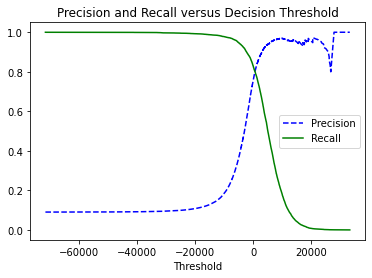

In [27]:
# Now, retrieve additional precision and retrieve data to draw precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, cv_prediction_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.title("Precision and Recall versus Decision Threshold")
plt.legend()
plt.show()

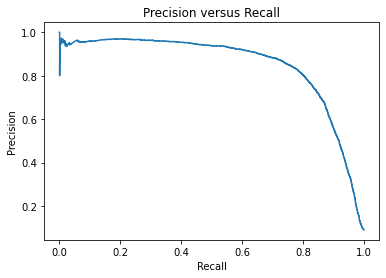

In [89]:
# Another way to select good precision/recall trade-off is to 
# plot the precision directly against the recall 

plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision versus Recall")
plt.show()

It is clear from the above plot that precision starts falling sharply after 80%. So, precision-recall trade-off can be selected just before that drop. If certain application requires higher precision, then the threshold can be decided as follows.

In [28]:
expected_precision = 0.90
required_threshold = thresholds[np.argmax(precisions >= expected_precision)]
print("Required threshold for {} percent precision is {}".format(
    expected_precision*100, required_threshold))

Required threshold for 90.0 percent precision is 3045.925822705365


In [30]:
# Now, predict with that threshold
cv_prediction_90_precision = (cv_prediction_scores >= required_threshold)

# Calculate the precision and recall
print("Precision:", precision_score(y_train_5, cv_prediction_90_precision))
print("Recall:", recall_score(y_train_5, cv_prediction_90_precision))

Precision: 0.9002016129032258
Recall: 0.6589190186312488


### The Receiver Operating Characteristic (ROC) Curve

The ROC is also another common tool used with binary classifiers. It is similar to Precision-Recall curve, but instead plotting precison versus recall, it plots True Positive Rate (TPR) - also called Recall against False Positive Rate (FPR).

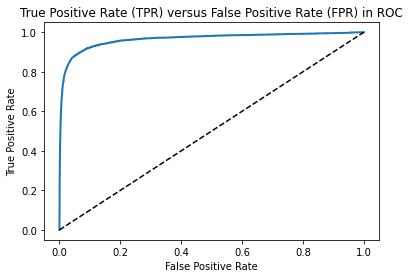

In [31]:
# Computes TRP and FPR
fpr, tpr, thresholds = roc_curve(y_train_5, cv_prediction_scores)

# Plots the ROC curve
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("True Positive Rate (TPR) versus False Positive Rate (FPR) in ROC")
plt.show()

One way to compare classifiers is to measure the Area Under Curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [32]:
# Let's find ROC AUC for SGD classifier
print(roc_auc_score(y_train_5, cv_prediction_scores))

0.9648211175804801


**Rule of Thumb:** As a rule of thumb, Precisio-Recall curve should be used if positive class is rare, otherwise ROC curve can be used.

### Performance Comparison

Let's compare the performance of SGD Classifier with that of the Random Forest Classifier.

In [33]:
# Instatiates Random Forest classifier
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Predicts the probabilities over cross-validation

# NOTE: This step may take several seconds to complete
cv_prediction_probas = cross_val_predict(rf_clf, X_train, y_train_5, cv=5, method="predict_proba")

In [35]:
# Check how prediction probabilities look like
print(cv_prediction_probas)

[[0.14 0.86]
 [0.99 0.01]
 [0.98 0.02]
 ...
 [0.01 0.99]
 [0.96 0.04]
 [0.96 0.04]]


Each row from the above CV prodictions probabilities is for prediction for each observation, and values in list represent probability distribution amongst classes (there are two classes here).

In [36]:
# Let's consider CV prediction probability only for positive class as it is 
# required to perform comparison with other classifier

cv_prediction_probas = cv_prediction_probas[:, 1]
print(cv_prediction_probas)

[0.86 0.01 0.02 ... 0.99 0.04 0.04]


In [37]:
# Computes FPR and TPR over prediction probabilities from Random Forest classifier
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, cv_prediction_probas)

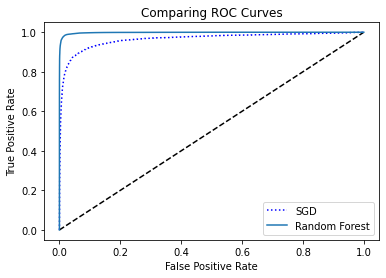

In [39]:
# Now, plots both ROC curves to compare performance

plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Comparing ROC Curves")
plt.show()

Random Forest ROC curves looks much better SGD Classifier's.

In [40]:
# Now, calcalates Random Forest's ROC AUC score

print(roc_auc_score(y_train_5, cv_prediction_probas))

0.998402186461512


The above ROC AUC score for Random Forest is more than that of SGD Classifier.

Let's now retrieve prediction from Random Forest classifier, and then calculates a few important metrics.

In [41]:
cv_predictions_rf = cv_prediction_probas >= 0.5

In [49]:
print("Random Forest Performance Summary:")
print()
print("Precision:", precision_score(y_train_5, cv_predictions_rf))
print("Recall:", recall_score(y_train_5, cv_predictions_rf))
print("F1:", f1_score(y_train_5, cv_predictions_rf))
print("ROC AUC:", roc_auc_score(y_train_5, cv_prediction_probas))

Random Forest Performance Summary:

Precision: 0.9904405652535329
Recall: 0.8791735842095554
F1: 0.9314961399394116
ROC AUC: 0.998402186461512
